In [149]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [150]:
# a few utilities and constants

# Constants
## fixme: check where these came from -- slightly different than Fay (1971)
K1=1.53
K2=1.21

visc_w = 1e-6 # viscoscity of water: m^2/s

g = 9.806 # gravity, m/s^2
rho_water = 1025.0 # kg/m^3 (typical seawater)

def Delta(rho_oil):
    return (float(rho_water) - rho_oil) / rho_water

def init_area(V0, rho_oil):
    """
    initial area -- end of Fay gravity-inertial
    """
    return np.pi * (K1**4/K2**2) * ((g * V0**5 * Delta(rho_oil))/visc_w**2 )**(1./6.) 

def init_radius(V0, rho_oil):
    """
    initial radius -- end of Fay gravity-inertial
    """
    return  (K1**2/K2) * ((g * V0**5 * delta())/visc_w**2 )**(1./12.) 

def min_thickness(visc_oil):
    if visc_oil <= 1e-6:
        return 1e-5    
    elif visc_oil >= 1e-4:
        return 1e-4
    else:
#        return 1e-5 + 0.1 * (visc_oil - 1e-6)
        return 1e-5 + 0.9090909090909090909 * (visc_oil - 1e-6)


def max_area(visc_oil, volume):
    volume / min_thickness

def Fay_gv(V0, rho_oil, t):
    """
    Fay Gravity-viscous phase analytical solution
    """
    return np.pi * K2**2 * (Delta(rho_oil) * g * V0**2/np.sqrt(visc_w))**(1./3) * np.sqrt(t)


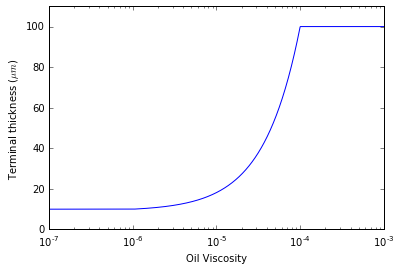

In [151]:
# plot thickness computation
nu_oil = np.logspace(-7,-3, 1000)
fig, ax = plt.subplots()
delta = np.array([min_thickness(nu) for nu in nu_oil])
#ax.plot(nu_oil, delta * 1e-6)
ax.semilogx(nu_oil, delta * 1e6)
ax.set_xlim(1e-7, 1e-3)
ax.set_ylim(0, 110)
ax.set_xlabel("Oil Viscosity")
ax.set_ylabel("Terminal thickness ($\mu m$)")

In [152]:
half = (1e-4 - 1e-6) / 2.0 + 1e-6
for nu in [9.999e-7, 1e-6, 1.0000001e-6, 1e-5, half, 9.9999999e-5, 1e-4, 1.1e-4]:
    d = min_thickness(nu)
    print "nu: %.8e, delta: %.8e"%(nu, d)

nu: 9.99900000e-07, delta: 1.00000000e-05
nu: 1.00000000e-06, delta: 1.00000000e-05
nu: 1.00000010e-06, delta: 1.00000001e-05
nu: 1.00000000e-05, delta: 1.81818182e-05
nu: 5.05000000e-05, delta: 5.50000000e-05
nu: 9.99999990e-05, delta: 9.99999991e-05
nu: 1.00000000e-04, delta: 1.00000000e-04
nu: 1.10000000e-04, delta: 1.00000000e-04



# Fay converted to a function of area

## Original Fay Spreading (Gravity-viscous)

$A(t) = \pi \cdot k_{\nu}  ( \frac{\Delta \rho \cdot g \cdot V^2 \cdot t^{3/2}}{\nu_w^{1/2}})$



## First the math/numerics  without real numbers:

$ C = \pi \cdot k_{\nu}  ( \frac{\Delta \rho \cdot g \cdot V^2}{\nu_w^{1/2}})$

$A = C t^{1/2}$

$ \frac{dA}{dt} = \frac{1}{2}C t^{-1/2} $

$ \frac{dA}{dt} = \frac{1}{2} \frac{C^2}{A} $

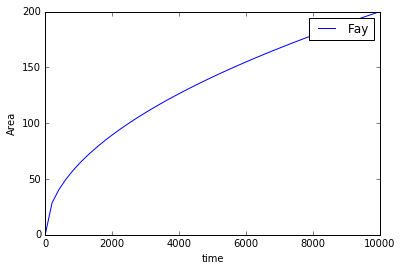

In [153]:
# as a function of time:
C = 2 # shouldn't be 1! more likely to find errors this way!
T = np.linspace(0, 10000)
A1 = C * np.sqrt(T)

fig, ax = plt.subplots()
ax.plot(T, A1, label="Fay")
ax.legend()
ax.set_xlabel("time")
ax.set_ylabel("Area")


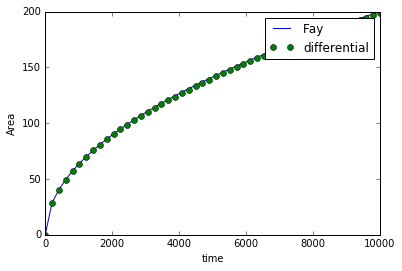

In [154]:
# as a differential equation:
def dadt(t):
    return 0.5 * C / np.sqrt(t)

# simple Euler method:
start = 10 # initilize with Fay
A2 = np.zeros_like(T)
A2[:start] = A1[:start]
dt = T[1] - T[0] # assume it's the same...
for i, t in enumerate(T[start:]):
    i += start
    A2[i] = A2[i-1] + dadt(t)*dt

fig, ax = plt.subplots()
ax.plot(T, A1, label="Fay")
ax.plot(T, A2, 'o', label="differential")
ax.legend()
ax.set_xlabel("time")
ax.set_ylabel("Area")


Note how the solutions sit right on top of each-other if you initialize right and use small enough time steps.

**NOTE:** maybe try RK method?

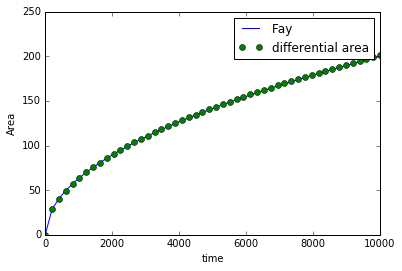

In [155]:
# differential equation in terms of Area

# initilize from Fay time dependent:
start = 10

def dadt(a):
    return 0.5 * C**2  / a

# simple Euler method:
A3 = np.zeros_like(T)
# small initial value to kick it off
A3[:start] = A1[:start]
dt = T[1] - T[0] # assume it's the same...
for i, t in enumerate(T[start:]):
    i += start
    A3[i] = A3[i-1] + dadt(A3[i-1])*dt
    
fig, ax = plt.subplots()
ax.plot(T, A1, label="Fay")
ax.plot(T, A3, 'o', label="differential area")
ax.legend()
ax.set_xlabel("time")
ax.set_ylabel("Area")

Solution exactly the same also -- with small enough time steps and the right initiliation.

## Compute with some real numbers:

$ C = \pi \cdot k_{\nu}  ( \frac{\Delta \rho \cdot g \cdot V^2}{\nu_w^{1/2}})$


In [156]:
# Some values to play with:
rho_oil = 900 # density of oil
vol = 795 # initial volume (m^3 -- 5000bbl)

C = np.pi * K1 * ( Delta(rho_oil) * g * vol**2 / np.sqrt(visc_w) )
print "C = ", C


C =  3632901286.62


timestep: 110.769230769 minutes


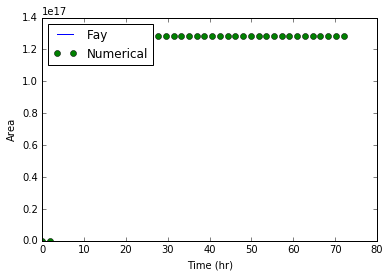

In [158]:
# differential equation in terms of Area

# Time zero to 72 hrs
T = np.linspace(0, 72*3600, 40)

print "timestep:", (T[1] - T[0]) / 60, "minutes"

#Fay_area = C * np.sqrt(T) # straight Fay Gravity-viscous
Fay_area = Fay_gv(vol, rho_oil, T)


A_0 = init_area(vol, rho_oil)


# initilize from Fay time dependent:
start = 2

def dadt(a):
    return 0.5 * C**2  / a

# simple Euler method:
A = np.zeros_like(T)
# small initial value to kick it off
A[:start] = Fay_area[:start]
dt = T[1] - T[0] # assume it's the same...
for i, t in enumerate(T[start:]):
    i += start
    A[i] = A[i-1] + dadt(A[i-1])*dt

Thr = T / 3600
fig, ax = plt.subplots()
ax.plot(Thr, Fay_area, label="Fay")
ax.plot(Thr, A, 'o',label="Numerical")
ax.legend(loc='upper left')
ax.hlines(A_0, Thr[0], Thr[-1])
#ax.annotate('initial area', 24, A_0)

ax.set_xlabel("Time (hr)")
ax.set_ylabel("Area")

**NOTE:** The numerical solution closely matches the analytic solution with a time step of about 2 hours. Indicating that the Euler method is accurate enough for timesteps on order of an hour or less.

In [ ]:
vol